# Линейный классификатор Softmax 

Для выполнения этого задания нужно будет дописать код в этом ноутбуке  

В этом упражнении Вам предстоит:

- реализовать функцию потерь (**loss**) для Softmax классификатора
- реализовать векторизованную функцию для вычисления **аналитического градиента**
- **проверить свою реализацию** с градиентом, вычисленным методом конечных разностей
- **найти лучшие learning rate и regularization** с помощью валидационной выборки
- **оптимизировать** функцию потерь с помощью градиентного спуска **SGD**
- **визуализировать** матрицу оптимальных весов.


In [1]:
# Load data
%%bash
git clone https://github.com/balezz/modern_dl.git
cd modern_dl
mkdir data
cd data
wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz -O cifar-10-python.tar.gz
tar -xzvf cifar-10-python.tar.gz 

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


Cloning into 'modern_dl'...
--2021-09-08 16:28:45--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

     0K .......... .......... .......... .......... ..........  0% 1.05M 2m34s
    50K .......... .......... .......... .......... ..........  0% 2.50M 1m50s
   100K .......... .......... .......... .......... ..........  0% 12.7M 77s
   150K .......... .......... .......... .......... ..........  0% 16.1M 61s
   200K .......... .......... .......... .......... ..........  0% 3.26M 58s
   250K .......... .......... .......... .......... ..........  0% 23.8M 50s
   300K .......... .......... .......... .......... ..........  0% 31.1M 43s
   350K .......... .......... .......... .......... ..........  0%

In [2]:
%cd modern_dl  

/content/modern_dl


In [3]:
import random
import numpy as np
from lib.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

# Загрузка датасета CIFAR-10 и предварительная подготовка

In [4]:
# Путь к папке с данными
cifar10_dir = 'data/cifar-10-batches-py'

# Очистим значения переменных, чтобы избежать проблем с излишним потреблением памяти
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Проверим размер входных и выходных векторов.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


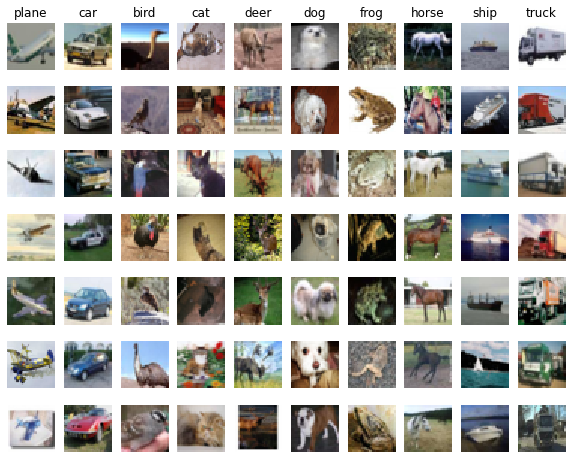

In [5]:
# Перед началом работы полезно посмотреть на данные.
# Отобразим пример из каждого класса.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
# Разделим данные на выборки train, val, test

num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Для валидации используем подвыборку train
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# На остальных данных из train будем тренировать модель
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# Чтобы ускорить разработку, создадим также небольшую dev выборку 
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# Для тестирования используем оригинальную выборку test
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [7]:
# Для удобства преобразуем двумерные изображения в одномерные вектора
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# Проверим размер полученных данных
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


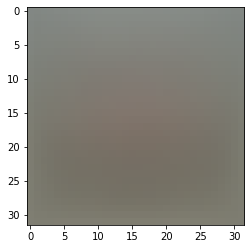

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [8]:
# Нормализуем значения яркости пикселей 
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) 

# визуализируем среднюю яркость
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) 
plt.show()

# Вычтем средние значения яркости
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# Добавим к вектору исходных данных фиктивный признак с постоянным значением 1.
# Этот трюк позволит избежать лишних вычислений: x @ W + b  => x' @ W'
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## Softmax Classifier


In [9]:
import time
import numpy as np
from random import shuffle

In [14]:
# Реализуйте функцию вычисления softmax loss и dW с помощью циклов

def softmax_loss_naive(W, X, y, reg):
    """
    Inputs have dimension D, there are C classes, and we operate on minibatches
    of N examples.
    Inputs:
    - W: A numpy array of shape (D, C) containing weights.
    - X: A numpy array of shape (N, D) containing a minibatch of data.
    - y: A numpy array of shape (N,) containing training labels; y[i] = c means
      that X[i] has label c, where 0 <= c < C.
    - reg: (float) regularization strength
    Returns a tuple of:
    - loss as single float
    - gradient with respect to weights W; an array of same shape as W
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using explicit loops.     #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    N = len(X)
    for n in range(N):
      z = X[n] @ W
      s = np.exp(z) / np.exp(z).sum()
      target_index = y[n]
      loss += - np.log(s[target_index])
      
      dL_dz = s.copy()
      dL_dz[target_index] -= 1
      
      dW += X[n].T.reshape(-1, 1) * dL_dz.reshape(1, -1)
    
    dW /= N
    loss /= N

    loss += np.linalg.norm(W) * reg 

    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return loss, dW


In [11]:
# Инициализируем веса значениями близкими, но не равными нулю
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# Проверим правильность реализации
# Для 10 классов loss должен быть около -log(0.1).
print('loss: %f' % loss)
print('Начальное значение Loss = %f' % (-np.log(0.1)))

loss: 2.381748
Начальное значение Loss = 2.302585


**Вопрос 1**

Объясните, почему мы предположили, что для 10 классов при весах близких к нулю
 softmax loss приблизительно равен -log(0.1)?  
$\color{blue}{\textit Ответ:}$ *заполнить здесь* 


In [59]:
# Теперь реализуйте более эффективную векторизованную версию 
# функции вычисления loss и dW

def softmax_loss_vectorized(W, X, y, reg):
    """
    Softmax loss function, vectorized version.
    Inputs and outputs are the same as softmax_loss_naive.
    """
    # Initialize the loss and gradient to zero.
    loss = 0.0
    dW = np.zeros_like(W)

    #############################################################################
    # TODO: Compute the softmax loss and its gradient using no explicit loops.  #
    # Store the loss in loss and the gradient in dW. If you are not careful     #
    # here, it is easy to run into numeric instability. Don't forget the        #
    # regularization!                                                           #
    #############################################################################
    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    N = len(X)
    Z = X @ W 
    Exps = np.exp(Z)
    # S.shape = N, C
    S = Exps / Exps.sum(axis=1).reshape(-1, 1)
    # loss.shape = 1
    loss = - np.log(S).sum() / N 
    loss += np.linalg.norm(W) * reg 
    # dL_dz.shape = N, C
    dL_dz = S.copy()
    dL_dz[range(N), y] -= 1
    dW = X.T @ dL_dz
    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    dW /= N
    return loss, dW

In [52]:
np.linalg.norm(np.random.random((3072, 10))) * 1e-3

0.10135951087310413

In [60]:
# Оценим, насколько быстрее стали вычисления
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# Для оценки близости двух матриц градиентов используем норму Фробениуса
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.381748e+00 computed in 0.105627s
vectorized loss: 2.344363e+01 computed in 0.012049s
Loss difference: 21.061878
Gradient difference: 0.000000


# Стохастический градиентный спуск

In [48]:
# Реализуйте SGD и проверьте результат 

class Softmax():
    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):
        """
        Обучение классификатора с помощью стохастического градиентного спуска
        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        - y: A numpy array of shape (N,) containing training labels; y[i] = c
          means that X[i] has label 0 <= c < C for C classes.
        - learning_rate: (float) learning rate for optimization.
        - reg: (float) regularization strength.
        - num_iters: (integer) number of steps to take when optimizing
        - batch_size: (integer) number of training examples to use at each step.
        - verbose: (boolean) If true, print progress during optimization.
        Outputs:
        A list containing the value of the loss function at each training iteration.
        """
        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            # lazily initialize W
            self.W = 0.001 * np.random.randn(dim, num_classes)

        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            #########################################################################
            # TODO:                                                                 #
            # Sample batch_size elements from the training data and their           #
            # corresponding labels to use in this round of gradient descent.        #
            # Store the data in X_batch and their corresponding labels in           #
            # y_batch; after sampling X_batch should have shape (batch_size, dim)   #
            # and y_batch should have shape (batch_size,)                           #
            #                                                                       #
            # Hint: Use np.random.choice to generate indices. Sampling with         #
            # replacement is faster than sampling without replacement.              #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
            idxs = np.random.randint(0, num_classes, batch_size)
            X_batch = X[idxs]
            y_batch = y[idxs]


            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # perform parameter update
            #########################################################################
            # TODO:                                                                 #
            # Update the weights using the gradient and the learning rate.          #
            #########################################################################
            # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            self.W -= grad*learning_rate

            # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.
        Inputs:
        - X: A numpy array of shape (N, D) containing training data; there are N
          training samples each of dimension D.
        Returns:
        - y_pred: Predicted labels for the data in X. y_pred is a 1-dimensional
          array of length N, and each element is an integer giving the predicted
          class.
        """
        y_pred = np.zeros(X.shape[0])
        ###########################################################################
        # TODO:                                                                   #
        # Implement this method. Store the predicted labels in y_pred.            #
        ###########################################################################
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

        z = X @ self.W
        y_pred = np.argmax(z, axis=1)
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return y_pred

    def loss(self, X_batch, y_batch, reg):
        """
        Compute the loss function and its derivative.
        Subclasses will override this.
        Inputs:
        - X_batch: A numpy array of shape (N, D) containing a minibatch of N
          data points; each point has dimension D.
        - y_batch: A numpy array of shape (N,) containing labels for the minibatch.
        - reg: (float) regularization strength.
        Returns: A tuple containing:
        - loss as a single float
        - gradient with respect to self.W; an array of the same shape as W
        """
        return softmax_loss_vectorized(self.W, X_batch, y_batch, reg)


In [51]:
softmax_cls = Softmax()
tic = time.time()
loss_hist = softmax_cls.train(X_train, y_train, learning_rate=1e-4, reg=1e-5,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 5.824195
iteration 100 / 1500: loss 142.415773
iteration 200 / 1500: loss 138.229211
iteration 300 / 1500: loss 135.889717
iteration 400 / 1500: loss 135.359157
iteration 500 / 1500: loss 141.537438
iteration 600 / 1500: loss 140.657813
iteration 700 / 1500: loss 149.515078
iteration 800 / 1500: loss 140.899448
iteration 900 / 1500: loss 136.357851
iteration 1000 / 1500: loss 139.203026
iteration 1100 / 1500: loss 137.695246
iteration 1200 / 1500: loss 140.036852
iteration 1300 / 1500: loss 144.667196
iteration 1400 / 1500: loss 140.883001
That took 7.175292s


In [ ]:
# Построим график зависимости loss от количества итераций
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [41]:
# оцените точность предсказания на выборках train и val
y_train_pred = softmax_cls.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax_cls.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.150082
validation accuracy: 0.174000


# Поиск лучших гиперпараметров

In [ ]:
# Используйте валидационную выборку для выбора лучших гиперпараметров 
# (learning rate and regularization strength)
# Добейтесь точности не меньше 0.39 на выборке val.
# Используйте словарь results в котором 
# ключи - кортеж  (learning_rate, regularization_strength)
# значения - (training_accuracy, validation_accuracy)
# Точность вычисляется как отношение числа верно предсказанных классов 
# к объему выборки
results = {}
best_val = -1   
best_cls = None # Лучший экземпляр Softmax classifier 

################################################################################
# TODO:                                                                        #
# Напишите код, позволяющий найти лучшее значение гиперпараметров на val       #
# выборке. Для каждой комбинации гиперпараметров обучите классификатор      #
# на train выборке, вычислите точность на выборках train, val и сохраните      #
# результат в словарь results. Лучшее значение точности сохраните в best_val   #
# лучший классификатор - в best_svm                                            #
#                                                                              #
# Подсказка: чтобы уменьшить время обучения, используйте dev подвыборку.       #
# После того, как код будет реализован и отлажен, замените dev на train.       #
################################################################################

# Пример допустимых значений. Можете изменить на свое усмотрение.
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

pass

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Вывод результатов.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

In [ ]:

# Визуализируем результаты кросс-валидации
import math
import pdb

# pdb.set_trace()

x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# график accuracy на обучении
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.tight_layout(pad=3)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# график accuracy на валидации
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

# Точность на test выборке


In [42]:
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

NameError: ignored

In [ ]:
# Визуализируем веса W для каждого класса
w = best_softmax.W[:-1,:] # отбросим фиктивное измерение bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Масштабируем веса в значения от 0 до 255 для визуализации
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

# ПОЗДРАВЛЯЕМ!

Это конец задания. Не забудьте сохранить этот ноутбук и файл softmax.py